#  Initial Data Analysis (IDA): Corrosion Detection Dataset

This notebook performs an initial analysis of the corrosion detection dataset.  
Each sample folder may contain:

- An **RGB image** (`.jpg`, `.png`, etc.)
- A **corrosion mask**: `damaged_metal.png`
- An **undamaged metal mask**: `undamaged_metal.png`
- A **background mask**: `background.png`

We will analyze the structure and integrity of the dataset to determine which samples are suitable for model training.


## 1.  Counting Total Sample Folders

We begin by counting the number of folders in the dataset.  
Each folder represents one sample and may contain an RGB image and several masks.


In [ ]:
from pathlib import Path

DATA_ROOT = Path("/home/shared-data/AnnotierteBilder") # Defining root directory where data is stored

sample_folders = [f for f in DATA_ROOT.iterdir() if f.is_dir()]

print(f"Total samples: {len(sample_folders)}") # Printing number of samples



Total samples: 908


* We found 908 sample folders in the dataset directory. Each folder is expected to contain an RGB image and optional mask files, which we will evaluate in the next steps for completeness and usability.

## 2. Count How Many Masks Are Available

We check how many sample folders contain each of the three mask types:

- `damaged_metal.png` (corrosion mask)
- `undamaged_metal.png` (intact metal mask)
- `background.png` (non-metal / irrelevant areas)


In [ ]:
has_damaged_mask = 0 # Initialize counters
has_undamaged_mask = 0
has_background_mask = 0

for folder in sample_folders:
    if (folder / "damaged_metal.png").exists():
        has_damaged_mask += 1
    if (folder / "undamaged_metal.png").exists():
        has_undamaged_mask += 1
    if (folder / "background.png").exists():
        has_background_mask += 1

print(f"Samples with damaged_metal.png:   {has_damaged_mask}") 
print(f"Samples with undamaged_metal.png: {has_undamaged_mask}")
print(f"Samples with background.png:      {has_background_mask}")


Samples with damaged_metal.png:   888
Samples with undamaged_metal.png: 838
Samples with background.png:      872


* Most samples include all masks, with 888 corrosion masks, 838 undamaged metal masks, and 872 background masks available across the dataset.

## 3. Most Common File Names Across Folders

We collect and count the file names that appear across all sample folders.  
This helps us detect:
- Which file types are common (e.g., masks, images)
- Whether any unexpected or irrelevant files exist


In [7]:
from collections import Counter
import pandas as pd

# Count all file names found inside folders
all_filenames = []

for folder in sample_folders:
    for file in folder.iterdir():
        if file.is_file():
            all_filenames.append(file.name)

# Convert to frequency table
file_counts = pd.Series(Counter(all_filenames)).sort_values(ascending=False)

# Show top 20 most frequent files
file_counts.head(20)



damaged_metal.png                888
background.png                   872
undamaged_metal.png              838
under_subscribed.png               2
cl6tw3do89d8h08227wyu36y9.jpg      1
cl2w8y84b0x1u079z3n2c21p4.jpg      1
cl4a2x1ka7kie079i56ao0gmt.jpg      1
cl70sbnha0ppp07zp61ia8xn9.jpg      1
cl24t9ubx7zz40z8y6ssadv2f.jpg      1
cl66zbkco0ci007yj4ltfed4o.jpg      1
cl7g8ldcm5nk4070ffpum6xe7.jpg      1
cl2520v8m04n70z8t3tkx2ncu.jpg      1
cl3k4lbizduio07a3c0yxdbbj.jpg      1
cl4w0zm484w6r070c8saed7fs.jpg      1
cl5rf5arc374k082s60g6epsd.jpg      1
cl606ifsqwwz307zrhtp491q6.jpg      1
cl6o2wl151ney07258t2h8oml.jpg      1
cl2fycin63na90z7bhn3tas7o.jpg      1
cl3k3bthi01pb086hgqo62s17.jpg      1
cl6701x110el207xx6zsfezqs.jpg      1
dtype: int64

* We analyzed file names across all sample folders to identify common and unexpected patterns. The three mask files were found in most samples, while the remaining unique names are likely RGB images, each with a distinct name per sample folder.

## 4. Visual Inspection of Image and Masks

To better understand the dataset, we visualize 3 random samples.  
Each sample will display:
- The original RGB image
- Corrosion mask (`damaged_metal.png`)
- Undamaged metal mask (`undamaged_metal.png`)
- Background mask (`background.png`)

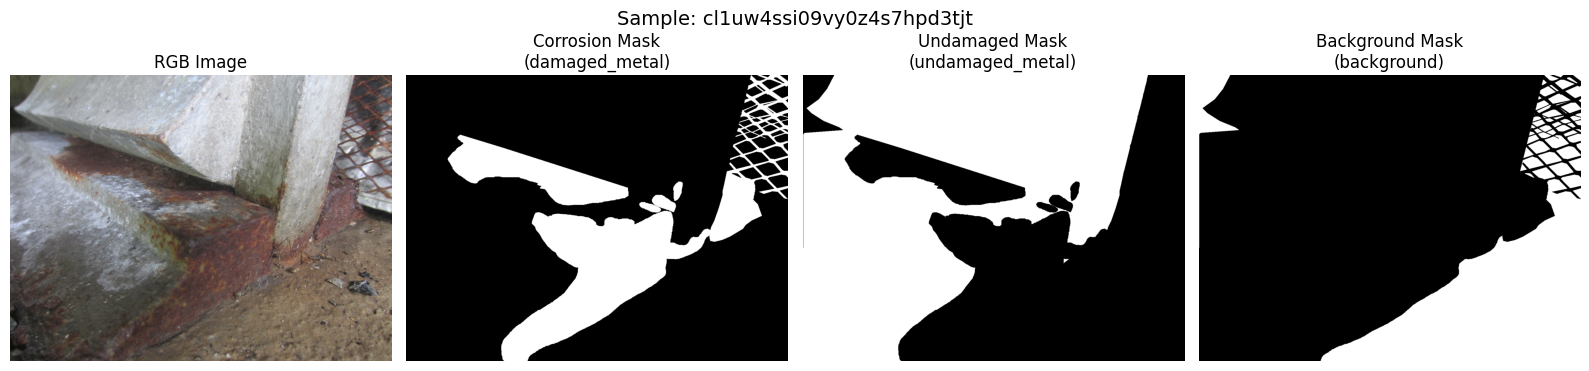

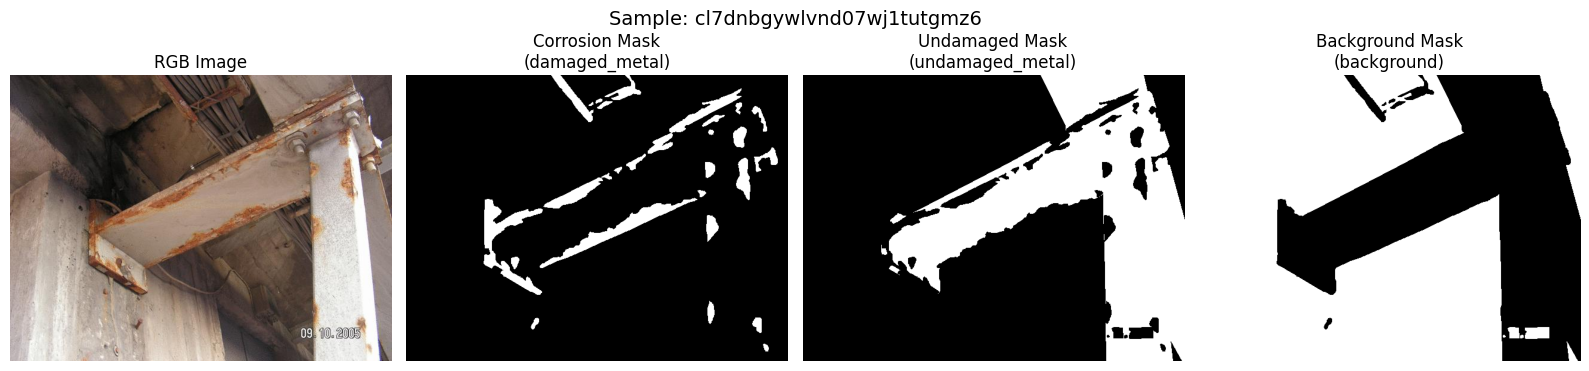

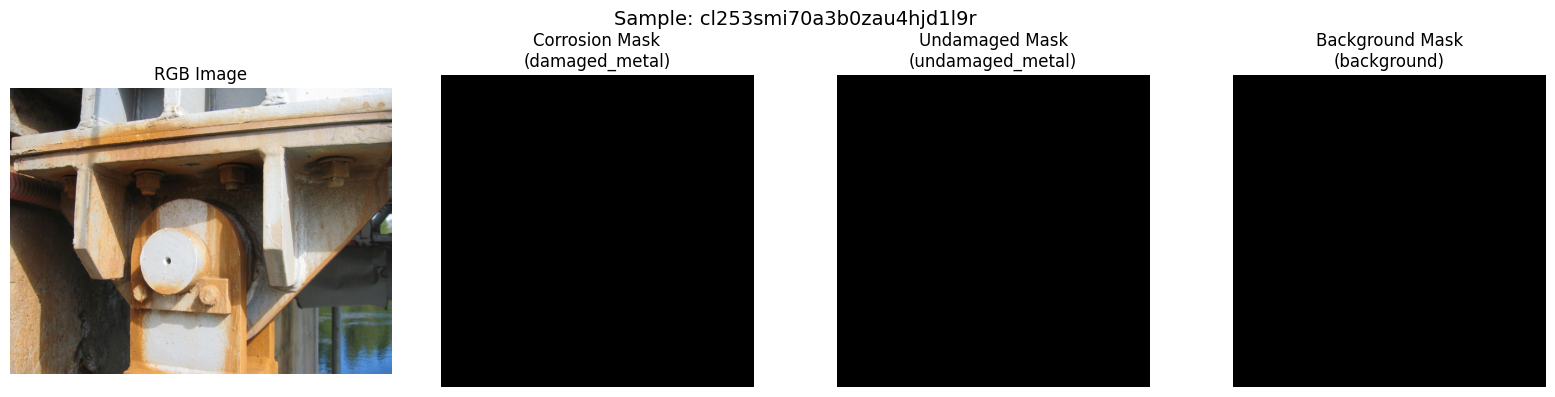

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

examples = []
count = 0

# Find 3 sample folders that contain at least 1 image
for folder in sample_folders:
    image_path = next(folder.glob("*.jpg"), None)
    if image_path:
        masks = {
            "Corrosion Mask\n(damaged_metal)": folder / "damaged_metal.png",
            "Undamaged Mask\n(undamaged_metal)": folder / "undamaged_metal.png",
            "Background Mask\n(background)": folder / "background.png"
        }
        examples.append((folder.name, image_path, masks))
        count += 1
    if count == 3:
        break

# Plotting
for sample_name, image_path, masks in examples:
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(f"Sample: {sample_name}", fontsize=14)

    # RGB image
    img = Image.open(image_path)
    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title("RGB Image")

    # Show each mask if it exists
    for idx, (title, path) in enumerate(masks.items(), start=1):
        if path.exists():
            mask = Image.open(path).convert("L")
            mask_array = np.array(mask) > 127
            axes[idx].imshow(mask_array, cmap="gray")
        else:
            axes[idx].imshow(np.zeros((100, 100)), cmap="gray")
            axes[idx].text(0.5, 0.5, "Missing", ha="center", va="center", transform=axes[idx].transAxes)

        axes[idx].axis("off")
        axes[idx].set_title(title)

    plt.tight_layout()
    plt.show()


## 5. Dataset Quality Audit Table

We generate a table summarizing the health of each sample folder.  
Each row includes:

- `sample`: folder name
- `rgb_ok`: is RGB image valid and readable?
- `dmg_ok`, `und_ok`, `bkg_ok`: are the masks present and readable?
- `size_match`: do the mask sizes match the RGB image size?
- File paths for image and each mask

This table will help us identify usable vs. unusable samples.


In [ ]:
import pandas as pd

# Helper to check if an image can be opened
def is_valid_image(p):
    try:
        with Image.open(p) as im:
            im.verify()
        return True
    except Exception:
        return False if p.exists() else None

rows = []

for folder in sample_folders:
    # Find RGB image
    rgb_path = next(folder.glob("*.jpg"), None)

    # Mask paths
    dmg_path = folder / "damaged_metal.png"
    und_path = folder / "undamaged_metal.png"
    bkg_path = folder / "background.png"

    # Check file validity
    rgb_ok = is_valid_image(rgb_path) if rgb_path else None
    dmg_ok = is_valid_image(dmg_path)
    und_ok = is_valid_image(und_path)
    bkg_ok = is_valid_image(bkg_path)

    # Check size match (if all valid)
    size_match = None
    if rgb_ok and dmg_ok:
        try:
            with Image.open(rgb_path) as rgb_img, Image.open(dmg_path) as dmg_img:
                size_match = (rgb_img.size == dmg_img.size)
        except:
            size_match = False

    rows.append({
        "sample": folder.name,
        "rgb": str(rgb_path) if rgb_path else "",
        "dmg": str(dmg_path) if dmg_path.exists() else "",
        "und": str(und_path) if und_path.exists() else "",
        "bkg": str(bkg_path) if bkg_path.exists() else "",
        "rgb_ok": rgb_ok,
        "dmg_ok": dmg_ok,
        "und_ok": und_ok,
        "bkg_ok": bkg_ok,
        "size_match": size_match
    })

# Creating DataFrame
df = pd.DataFrame(rows)

# Define output directory
OUT_DIR = Path.home() / "corrosion-detector" / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save to CSV
df.to_csv(OUT_DIR / "ida_file_audit2.csv", index=False)

# Show preview
df.head(10)


,sample,rgb,dmg,und,bkg,rgb_ok,dmg_ok,und_ok,bkg_ok,size_match
0,cl1uw4ssi09vy0z4s7hpd3tjt,/home/shared-data/AnnotierteBilder/cl1uw4ssi09...,/home/shared-data/AnnotierteBilder/cl1uw4ssi09...,/home/shared-data/AnnotierteBilder/cl1uw4ssi09...,/home/shared-data/AnnotierteBilder/cl1uw4ssi09...,True,True,True,True,True
1,cl7dnbgywlvnd07wj1tutgmz6,/home/shared-data/AnnotierteBilder/cl7dnbgywlv...,/home/shared-data/AnnotierteBilder/cl7dnbgywlv...,/home/shared-data/AnnotierteBilder/cl7dnbgywlv...,/home/shared-data/AnnotierteBilder/cl7dnbgywlv...,True,True,True,True,True
2,cl253smi70a3b0zau4hjd1l9r,/home/shared-data/AnnotierteBilder/cl253smi70a...,,,,True,None,None,None,None
3,cl62wjzsq4j550712dzppceod,/home/shared-data/AnnotierteBilder/cl62wjzsq4j...,/home/shared-data/AnnotierteBilder/cl62wjzsq4j...,/home/shared-data/AnnotierteBilder/cl62wjzsq4j...,/home/shared-data/AnnotierteBilder/cl62wjzsq4j...,True,True,True,True,True
4,cl5zoki1wmxsk08ysc0i3gqlt,/home/shared-data/AnnotierteBilder/cl5zoki1wmx...,/home/shared-data/AnnotierteBilder/cl5zoki1wmx...,/home/shared-data/AnnotierteBilder/cl5zoki1wmx...,/home/shared-data/AnnotierteBilder/cl5zoki1wmx...,True,True,True,True,True
5,cl3womfut2iwc076qfo66frap,/home/shared-data/AnnotierteBilder/cl3womfut2i...,/home/shared-data/AnnotierteBilder/cl3womfut2i...,/home/shared-data/AnnotierteBilder/cl3womfut2i...,/home/shared-data/AnnotierteBilder/cl3womfut2i...,True,True,True,True,True
6,cl2ano73j0pwm108t0uznfx9c,/home/shared-data/AnnotierteBilder/cl2ano73j0p...,/home/shared-data/AnnotierteBilder/cl2ano73j0p...,/home/shared-data/AnnotierteBilder/cl2ano73j0p...,/home/shared-data/AnnotierteBilder/cl2ano73j0p...,True,True,True,True,True
7,cl4hldvvb362p087bb9trff5u,/home/shared-data/AnnotierteBilder/cl4hldvvb36...,/home/shared-data/AnnotierteBilder/cl4hldvvb36...,/home/shared-data/AnnotierteBilder/cl4hldvvb36...,/home/shared-data/AnnotierteBilder/cl4hldvvb36...,True,True,True,True,True
8,cl4hip3ui3coc074r2097gfto,/home/shared-data/AnnotierteBilder/cl4hip3ui3c...,/home/shared-data/AnnotierteBilder/cl4hip3ui3c...,/home/shared-data/AnnotierteBilder/cl4hip3ui3c...,/home/shared-data/AnnotierteBilder/cl4hip3ui3c...,True,True,True,True,True
9,cl670tqx30h79071key6z7q9l,/home/shared-data/AnnotierteBilder/cl670tqx30h...,/home/shared-data/AnnotierteBilder/cl670tqx30h...,/home/shared-data/AnnotierteBilder/cl670tqx30h...,/home/shared-data/AnnotierteBilder/cl670tqx30h...,True,True,True,True,True


## 6. Identify Incomplete or Broken Samples

We now filter the audit table to find sample folders that:

- Have a valid RGB image (`rgb_ok == True`)
- But are **missing** or **corrupt** in one or more of the masks:
  - `damaged_metal.png`
  - `undamaged_metal.png`
  - `background.png`

These samples will likely be excluded from model training. 

In [10]:
# Filter: RGB is OK but at least one mask is missing or invalid
incomplete_samples = df[
    (df["rgb_ok"] == True) &
    (
        (df["dmg_ok"] != True) |
        (df["und_ok"] != True) |
        (df["bkg_ok"] != True)
    )
]

print(f"Number of incomplete or broken samples: {len(incomplete_samples)}")

# Show a preview
incomplete_samples[["sample", "rgb_ok", "dmg_ok", "und_ok", "bkg_ok", "size_match"]].head()


Number of incomplete or broken samples: 92


,sample,rgb_ok,dmg_ok,und_ok,bkg_ok,size_match
2,cl253smi70a3b0zau4hjd1l9r,True,None,None,None,None
16,cl6dxtgz90yvi07vhdkxc1ijp,True,True,True,None,True
20,cl41j7i3r5wv9072t7yns4noy,True,True,True,None,True
23,cl7f9p5pf1wlb074chm702ykl,True,True,True,None,True
25,cl5a3b0l3005j080sgqk67zfm,True,True,None,True,True


* We identified 92 incomplete or broken samples in the dataset, where one or more expected files (RGB or masks) were missing or mismatched.

## 7.  Filter Fully Valid Samples for Model Training

To ensure reliable training, we now extract only the **clean** samples that meet all conditions. These are the most reliable samples in the dataset and will be used for all future training steps.


In [14]:
# Filter fully valid rows
valid_samples = df[
    (df["rgb_ok"] == True) &
    (df["dmg_ok"] == True) &
    (df["und_ok"] == True) &
    (df["bkg_ok"] == True) &
    (df["size_match"] == True)
]

print(f"✅ Number of fully usable samples: {len(valid_samples)}")

# Preview some
valid_samples[["sample", "rgb_ok", "dmg_ok", "und_ok", "bkg_ok", "size_match"]].head()
valid_samples.to_csv("fully_valid_samples.csv", index=False)



✅ Number of fully usable samples: 816


In [ ]:
import pandas as pd
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm

# Load the list of fully valid samples
df_valid = pd.read_csv("fully_valid_samples.csv")

# Define the root directory of your dataset
DATA_ROOT = Path("/home/shared-data/AnnotierteBilder")

# Create empty list to store pixel counts
pixel_data = []

# Loop through each valid sample
for sample in tqdm(df_valid['sample']):
    folder = DATA_ROOT / sample
    sample_result = {'sample': sample}

    for mask_name, col_name in [("damaged_metal.png", "damaged_pixels"),
                                ("undamaged_metal.png", "undamaged_pixels"),
                                ("background.png", "background_pixels")]:
        mask_path = folder / mask_name
        if mask_path.exists():
            mask = np.array(Image.open(mask_path))
            sample_result[col_name] = np.count_nonzero(mask)
        else:
            sample_result[col_name] = 0

    pixel_data.append(sample_result)

# Convert to DataFrame
df_pixel_counts = pd.DataFrame(pixel_data)

# Show preview


100%|██████████| 816/816 [03:45<00:00,  3.62it/s]


,sample,damaged_pixels,undamaged_pixels,background_pixels
0,cl1uw4ssi09vy0z4s7hpd3tjt,1620828,4199412,1859760
1,cl7dnbgywlvnd07wj1tutgmz6,82368,368392,778040
2,cl62wjzsq4j550712dzppceod,19714008,14550816,13735176
3,cl5zoki1wmxsk08ysc0i3gqlt,535088,3560988,819124
4,cl3womfut2iwc076qfo66frap,1244800,1936368,4498832


In [16]:
df_pixel_counts


,sample,damaged_pixels,undamaged_pixels,background_pixels
0,cl1uw4ssi09vy0z4s7hpd3tjt,1620828,4199412,1859760
1,cl7dnbgywlvnd07wj1tutgmz6,82368,368392,778040
2,cl62wjzsq4j550712dzppceod,19714008,14550816,13735176
3,cl5zoki1wmxsk08ysc0i3gqlt,535088,3560988,819124
4,cl3womfut2iwc076qfo66frap,1244800,1936368,4498832
...,...,...,...,...
811,cl41lsqzg6tlk087q2lvxf4zc,179776,272444,2693508
812,cl2knpcj2007m0z92f45k4ztr,7846600,1596704,26524696
813,cl4hhxn8722fy087y0740a2a8,6450844,11915496,5423228
814,cl1w4f2j417uj0zd0erme7yhe,119480,887816,2138432


In [17]:
# Basic stats for each mask type
df_pixel_counts[["damaged_pixels", "undamaged_pixels", "background_pixels"]].describe()


,damaged_pixels,undamaged_pixels,background_pixels
count,8.160000e+02,8.160000e+02,8.160000e+02
mean,2.937545e+06,6.052756e+06,8.229056e+06
std,5.091914e+06,9.688218e+06,9.691477e+06
min,3.310000e+04,2.016000e+03,8.528000e+03
25%,4.062060e+05,8.616520e+05,1.695375e+06
50%,1.041642e+06,2.207960e+06,4.095510e+06
75%,3.049456e+06,6.918832e+06,1.174318e+07
max,4.992760e+07,1.405646e+08,6.703317e+07


* The pixel count analysis shows that all mask types are present and vary in size across samples. On average, background occupies the most area, followed by undamaged and then damaged metal, with some samples showing very large or very small regions per class.

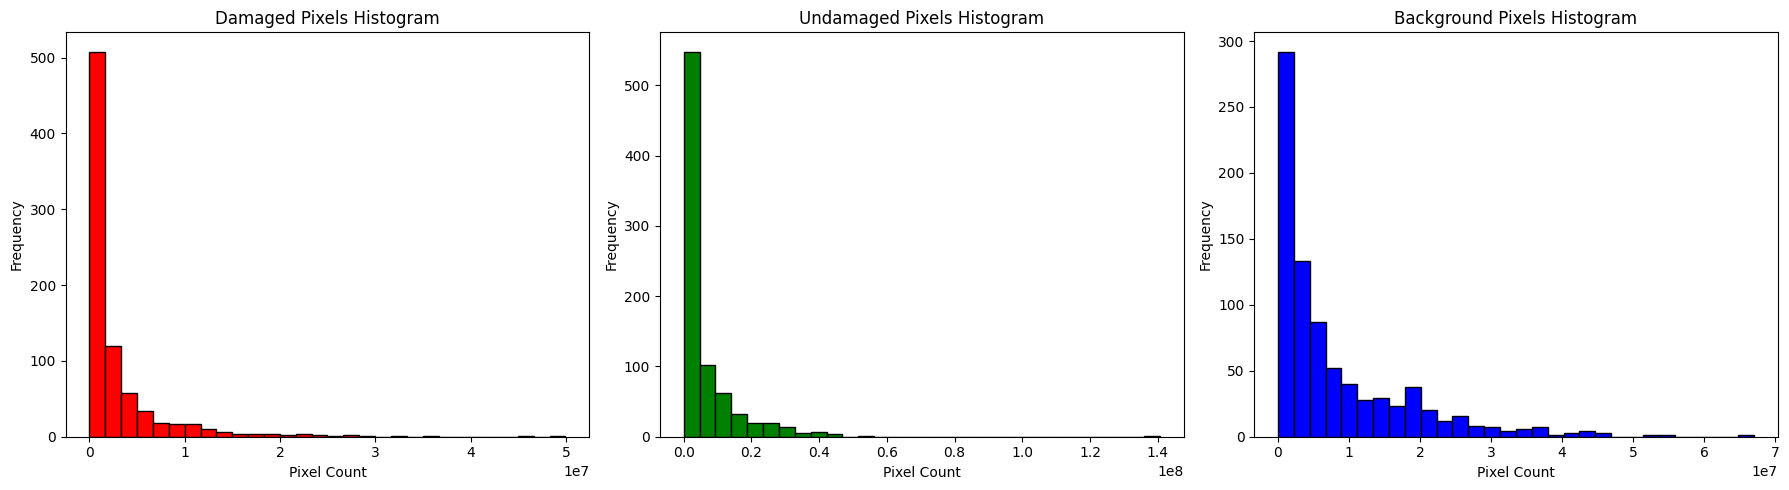

In [18]:
import matplotlib.pyplot as plt

# Plot histogram for each mask type
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, column, color in zip(
    axs,
    ["damaged_pixels", "undamaged_pixels", "background_pixels"],
    ["red", "green", "blue"]
):
    ax.hist(df_pixel_counts[column], bins=30, color=color, edgecolor="black")
    ax.set_title(f"{column.replace('_', ' ').title()} Histogram")
    ax.set_xlabel("Pixel Count")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


* The pixel distribution plots show that most samples have a small number of pixels labeled as damaged, while undamaged and background regions tend to occupy larger areas. All three masks are strongly skewed, with a few samples containing very large pixel regions, indicating class imbalance at the pixel level.